In [41]:
import librosa
import os, gc
import numpy as np
import random
import itertools

import pandas as pd

from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import matplotlib.pyplot as plt

from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance

In [3]:
PROJECT_PATH='/home/hmenn/Workspace/CSE455_MachineLearning_2018/Final_MusicClassification'

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, figsize=(6,6)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def extractMfccFeature(_path=None, _offset=12, _duration=6):
    try:
        # returns signal and sample rate
        signal, sr = librosa.load(path=_path, offset=_offset, duration=_duration)
                
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
        l = mfccs.shape[1]
        mfccs = mfccs[:, int(0.2 * l):int(0.8 * l)]

        mean = mfccs.mean(axis=1)
        covar = np.cov(mfccs, rowvar=1)

        mean.resize(1, mean.shape[0])
        # it returns matrix.. not useful for machine learning algorithms except KNN
        npArray = np.concatenate((mean, covar), axis=0)
        return npArray.flatten()
    except Exception as e:
        print ("Error accured" + str(e))
        return None

In [23]:
music_type_id = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
     'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
music_type_str = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

In [7]:
%%time
walk_dir = "genres"

all_input_data = []
all_input_class = []

for root, subdirs, files in os.walk(walk_dir):
    print("Walk on dir:",root,'Total File:',len(files))
    for filename in files:
        if filename.endswith('.au'):
            file_path = os.path.join(root, filename)
            feature = extractMfccFeature(file_path)

            all_input_data.append(feature)
            all_input_class.append(music_type_id[filename.split('.')[0]])

Walk on dir: genres Total File: 0
Walk on dir: genres/pop Total File: 100
Walk on dir: genres/blues Total File: 100
Walk on dir: genres/classical Total File: 100
Walk on dir: genres/country Total File: 100
Walk on dir: genres/hiphop Total File: 100
Walk on dir: genres/rock Total File: 100
Walk on dir: genres/reggae Total File: 100
Walk on dir: genres/metal Total File: 100
Walk on dir: genres/disco Total File: 100
Walk on dir: genres/jazz Total File: 100
CPU times: user 8min 5s, sys: 4min 21s, total: 12min 27s
Wall time: 7min 22s


### Shuffling all data

In [8]:
%%time
print("Shuffle input data to get better results")

all_input_shuffledData = np.asarray(all_input_data)
all_input_shuffledClass = np.asarray(all_input_class)

s = np.arange(all_input_shuffledData.shape[0])
np.random.shuffle(s)

all_input_shuffledData = all_input_shuffledData[s]
all_input_shuffledClass = all_input_shuffledClass[s]

print("->all_input_shuffledData:",all_input_shuffledData.shape)
print("->all_input_shuffledClass:",all_input_shuffledClass.shape)

Shuffle input data to get better results
->all_input_shuffledData: (1000, 420)
->all_input_shuffledClass: (1000,)
CPU times: user 8.14 ms, sys: 8.09 ms, total: 16.2 ms
Wall time: 7.86 ms


In [12]:
yt_data = []
yt_class = []

# CLASSICAL 
print('Classical')
classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=14, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=20, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=28, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

classical = extractMfccFeature(PROJECT_PATH+'/test/classicals.m4a', _offset=24, _duration=6)
yt_data.append(classical)
yt_class.append(music_type_id['classical'])

# JAZZ
print('Jazz')
jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=140, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=360, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=570, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])

jazz = extractMfccFeature(PROJECT_PATH+'/test/jazz.mp3', _offset=275, _duration=6)
yt_data.append(jazz)
yt_class.append(music_type_id['jazz'])
 
# POP
print('Pop')
pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=10, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=170, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=280, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=645, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

pop = extractMfccFeature(PROJECT_PATH+'/test/pop.m4a', _offset=1020, _duration=6)
yt_data.append(pop)
yt_class.append(music_type_id['pop'])

# BLUES
print('Blues')
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=40, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=105, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=668, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=420, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])
blues = extractMfccFeature(PROJECT_PATH+'/test/blues.mp3', _offset=800, _duration=6)
yt_data.append(blues)
yt_class.append(music_type_id['blues'])

# ROCK
print('Rock')
rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=15, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=21, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=28, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

rock = extractMfccFeature(PROJECT_PATH+'/test/rocks.m4a', _offset=25, _duration=6)
yt_data.append(rock)
yt_class.append(music_type_id['rock'])

# HIP HOP
print('HipHop')
hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=5, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=28, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=20, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop'])

hiphop = extractMfccFeature(PROJECT_PATH+'/test/hiphops.m4a', _offset=12, _duration=6)
yt_data.append(hiphop)
yt_class.append(music_type_id['hiphop']) 

# DISCO
print('Disco')
disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=2, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=16, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=28, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

disco = extractMfccFeature(PROJECT_PATH+'/test/disco.m4a', _offset=7, _duration=6)
yt_data.append(disco)
yt_class.append(music_type_id['disco'])

# COUNTRY
print('Country')
country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=123, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=425, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=12, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

country = extractMfccFeature(PROJECT_PATH+'/test/country.m4a', _offset=728, _duration=6)
yt_data.append(country)
yt_class.append(music_type_id['country'])

# REGGAE
print('Reggae')
reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=321, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=423, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=56, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

reggae = extractMfccFeature(PROJECT_PATH+'/test/reggae.m4a', _offset=124, _duration=6)
yt_data.append(reggae)
yt_class.append(music_type_id['reggae'])

Classical
Jazz
Pop
Blues
Rock
HipHop
Disco
Country
Reggae


### KNN

KNN Score:  0.353
CPU times: user 530 ms, sys: 47.4 ms, total: 577 ms
Wall time: 519 ms


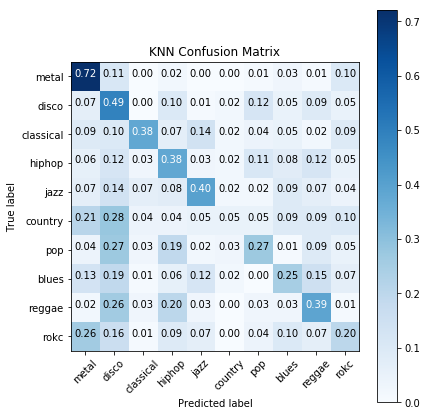

In [22]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

#yt_guess = []
#yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(knn.predict(X_test))

#    yt_guess.extend(knn.predict(yt_data))
#    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)

plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KNN Confusion Matrix')
print("KNN Score: ", accuracy_score(actual, guess))

'''
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='KNN YT Confusion Matrix')
print("KNN Youtube Score: ", accuracy_score(yt_guess, yt_actual))
'''

### SVM

SVM Score:  0.473
CPU times: user 16.1 s, sys: 16.2 ms, total: 16.1 s
Wall time: 16.1 s


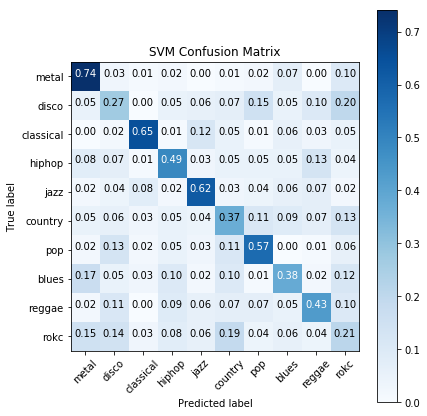

In [14]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

#yt_guess = []
#yt_actual = []

for trainIndex, testIndex in kf.split(all_input_shuffledData):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    svm1 = svm.LinearSVC(C=10, loss='squared_hinge', penalty='l2', tol=0.00001)
    svm1.fit(X_train,y_train)
    
    actual.extend(y_test)
    guess.extend(svm1.predict(X_test))

#    yt_guess.extend(svm1.predict(yt_data))
#    yt_actual.extend(yt_class)

coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='SVM Confusion Matrix')
print("SVM Score: ", accuracy_score(actual, guess))

'''
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='SVM YT Confusion Matrix')
print("SVM Youtube Score: ", accuracy_score(yt_guess, yt_actual))
'''

### Decision Tree

Decision Tree Score:  0.364
CPU times: user 2.02 s, sys: 58.8 ms, total: 2.08 s
Wall time: 2.03 s


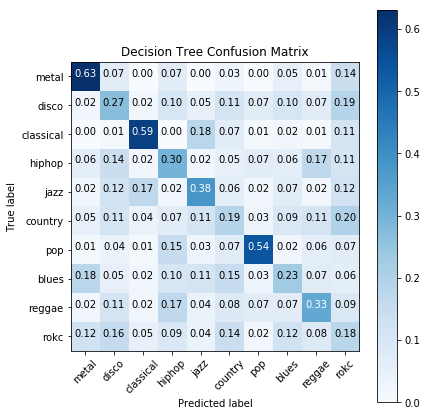

In [15]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
#    yt_guess.extend(dt.predict(yt_data))
#    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Decision Tree Confusion Matrix')        
print("Decision Tree Score: ", accuracy_score(actual, guess))

'''
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='Decision YT Confusion Matrix')
print("Decision Youtube Score: ", accuracy_score(yt_guess, yt_actual))
'''

### XGBoost

XGBoost Accuracy Score: 0.615
CPU times: user 9min 10s, sys: 2.04 s, total: 9min 12s
Wall time: 2min 43s


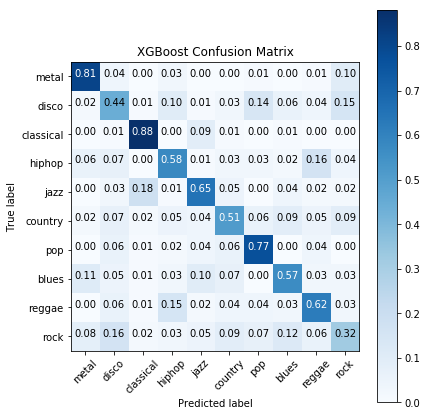

In [24]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(all_input_data):
    X_train, X_test = all_input_shuffledData[trainIndex], all_input_shuffledData[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    xgb_params = {
        'eta': 0.05,
        'max_depth': 5,
        'subsample': 0.9,
        'objective': 'multi:softmax',
        'silent': 1,
        'colsample_bytree': 0.9,
        'num_class':10
    }

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_test, y_test)
    
    model = xgb.train(xgb_params, d_train, num_boost_round = 240)
    
    actual.extend(y_test)
    guess.extend(model.predict(d_valid))
    
    #d_yt = xgb.DMatrix(yt_data, yt_class)
    #yt_guess.extend(model.predict(d_yt))
    #yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='XGBoost Confusion Matrix')
print('XGBoost Accuracy Score:',accuracy_score(actual, guess))

"""
coeff = confusion_matrix(yt_guess, yt_actual)
plot_confusion_matrix(coeff, classes=[Y_str[i] for i in range(10)], normalize=True,
                      title='XGBoost YT Confusion Matrix')
print("XGBoost Youtube Score: ", accuracy_score(yt_guess, yt_actual))
"""

### PCA + KMeans

Old features: (1000, 420)
Feature after PCA: (1000, 2)


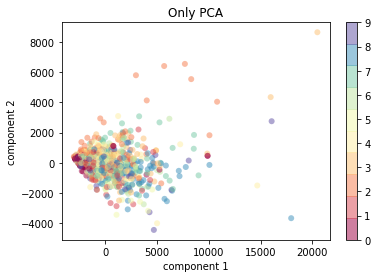

In [31]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(all_input_shuffledData)
print('Old features:',all_input_shuffledData.shape)
print('Feature after PCA:',projected.shape)

plt.scatter(projected[:, 0],projected[:, 1], #[0 for i in range(len(projected))]
            c=all_input_shuffledClass, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.title("Only PCA")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

KMeans Score:  0.19
CPU times: user 168 ms, sys: 48.9 ms, total: 216 ms
Wall time: 156 ms


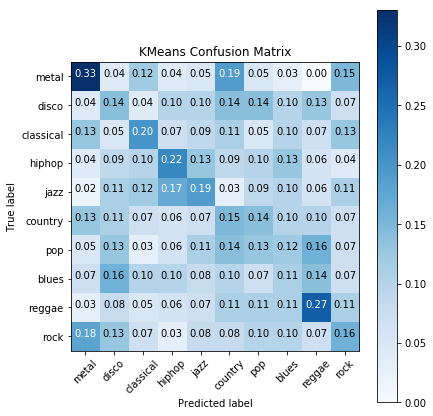

In [32]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(projected):
    X_train, X_test = projected[trainIndex], projected[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    clusterer = KMeansClusterer(k, euclidean_distance, repeats=10)
    clusters = clusterer.cluster(X_train, True)
    
    actual.extend(y_test)
    guess.extend(dt.predict(X_test))
    
#    yt_guess.extend(dt.predict(yt_data))
#    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='KMeans Confusion Matrix')        
print("KMeans Score: ", accuracy_score(actual, guess))

In [34]:
def part2(distance_method=euclidean_distance, data_x=projected[:1000], data_y=all_input_shuffledClass[:1000]):
    
    k = 10

    print('Data Shape:',data_x.shape,'\n')

    kf = KFold(n_splits=5)
    kFoldIndex = 1
    
    allTrainY = []
    allTrainGuess = []
    allTestY = []
    allTestGuess = []
    
    for trainIndex, testIndex in kf.split(data_x):
        print(' #########  KFold Step:', kFoldIndex,'  #########')

        kTrainX, kTestX = data_x[trainIndex], data_x[testIndex]
        kTrainY, kTestY = data_y[trainIndex], data_y[testIndex]

        clusterer = KMeansClusterer(k, distance_method, repeats=10)
        clusters = clusterer.cluster(kTrainX, True)

        table = np.zeros((10,10))

        for l,c in zip(kTrainY, clusters):
            table[l][c] = table[l][c] + 1

        df = pd.DataFrame(data=table, columns = ['C'+str(i) for i in range(k)])
        print('Table:\n',df,'\n')

        flattenTable = table.flatten()
        flattenTable[::-1].sort()

        orders = []
        for d in flattenTable:
            ind = np.where(table==d)
            for j in zip(*ind):
                orders.append(j)

        # label clusters according to explanation which exist in hw pdf
        labelsRow = {}
        labelsCol = {}
        i = 0
        while True:
            row = orders[i][0]
            col = orders[i][1]

            if (not row in labelsRow) and (not col in labelsCol):
                labelsRow[row] = (row,col, table[row][col])
                labelsCol[col] = (row,col, table[row][col])

            if len(labelsRow) == k:
                break

            i = i + 1

        clusterLabels = {}
        for i in range(k):
            clusterLabels[labelsRow[i][1]] = labelsRow[i][0]
            print('Cluster:',labelsRow[i][1],' assigned Label:',labelsRow[i][0], ' Value:', labelsRow[i][2])
        print('\n')

        allTrainY.extend(kTrainY)
        for c in clusters:
            allTrainGuess.append(clusterLabels[c])

        allTestY.extend(kTestY)
        for t in kTestX:
            allTestGuess.append(clusterLabels[clusterer.classify(t)])

        kFoldIndex = kFoldIndex + 1 
    return    allTrainY, allTrainGuess, allTestY, allTestGuess

In [37]:
%%time
allTrainY1 , allTrainGuess1, allTestY1, allTestGuess1 = part2(distance_method=euclidean_distance, data_x=projected[:1000], data_y=all_input_shuffledClass[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6   C7    C8   C9
0  54.0  15.0   1.0   1.0   1.0   2.0   0.0  1.0   1.0  2.0
1   7.0  30.0  18.0  18.0   3.0   6.0   4.0  1.0   1.0  0.0
2  28.0  13.0  10.0   0.0  11.0   5.0   4.0  7.0   0.0  3.0
3   6.0  12.0   4.0  10.0  11.0  15.0   7.0  9.0   5.0  3.0
4  17.0  12.0  12.0   3.0  14.0  12.0   7.0  2.0   0.0  1.0
5  15.0  23.0  16.0  11.0   3.0   4.0   5.0  0.0   0.0  0.0
6   6.0  14.0  12.0  12.0   6.0  18.0   9.0  2.0   1.0  0.0
7   9.0  18.0   5.0   7.0   5.0  12.0   7.0  7.0   9.0  0.0
8   0.0   4.0  17.0  13.0   4.0   9.0  21.0  2.0  11.0  2.0
9  26.0  15.0   9.0   2.0   4.0   8.0   4.0  1.0   2.0  1.0 

Cluster: 0  assigned Label: 0  Value: 54.0
Cluster: 1  assigned Label: 1  Value: 30.0
Cluster: 7  assigned Label: 2  Value: 7.0
Cluster: 3  assigned Label: 3  Value: 10.0
Cluster: 4  assigned Label: 4  Value: 14.0
Cluster: 2  assigned Label: 5  Value: 16.0
Cluster: 5 

KMeans Score:  0.19


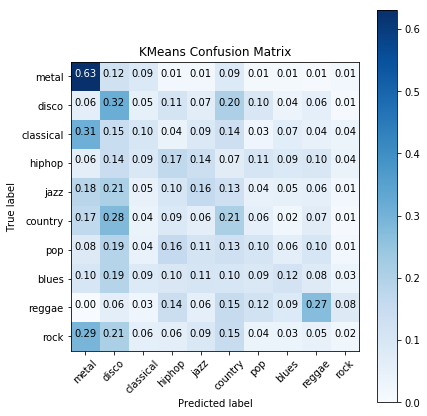

In [40]:
coeff = confusion_matrix(allTrainY1, allTrainGuess1)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True, title='KMeans Confusion Matrix')        
print("KMeans Score: ", accuracy_score(actual, guess))
#print('Euclidean_distance, Test Confusion Matrix Accuracy:', calcConfusionMatrixAcc(confusion_matrix(allTestY1, allTestGuess1)))

Random Forest Score:  0.226
CPU times: user 238 ms, sys: 59.6 ms, total: 298 ms
Wall time: 231 ms


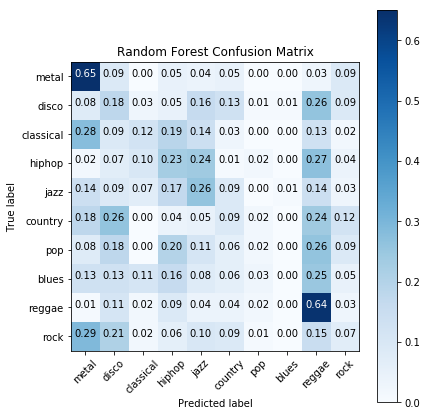

In [42]:
%%time
kf = KFold(n_splits=5)

guess = []
actual = []

yt_guess = []
yt_actual = []

for trainIndex, testIndex in kf.split(projected):
    X_train, X_test = projected[trainIndex], projected[testIndex]
    y_train, y_test = all_input_shuffledClass[trainIndex], all_input_shuffledClass[testIndex]
    
    clf = RandomForestClassifier(max_depth=2, random_state=0)
    clf.fit(X_train, y_train)
 
    actual.extend(y_test)
    guess.extend(clf.predict(X_test))
    
#    yt_guess.extend(dt.predict(yt_data))
#    yt_actual.extend(yt_class)
    
coeff = confusion_matrix(actual, guess)
plot_confusion_matrix(coeff, classes=music_type_str, normalize=True,
                      title='Random Forest Confusion Matrix')        
print("Random Forest Score: ", accuracy_score(actual, guess))

In [17]:
# run garbage collector manually
gc.collect()

30197